In [1]:
import sys
sys.path.insert(0, '/Users/james/Desktop/DRL_Hedging')
import numpy as np
import matplotlib.pyplot as plt
from financial_models.asset_price_models import GBM
from financial_models.option_price_models import BSM
from hedging_env_gymnasium_a import HedgingEnv
from baseline_agent import DeltaNeutralAgent
from tqdm import tqdm
import seaborn as sns
from Utils import evaluate_delta_policy


seed = 345
np.random.seed(seed)


mu = 0.05
D = 5
T = 30
num_steps = T*D
s_0 = 100
strike_price = s_0
sigma = 0.15
r = 0.02
trading_cost_para=0.003
L=100

apm = GBM(mu=mu, dt=1/(252*D), s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T/252, dt=1/(252*D))
env = HedgingEnv(asset_price_model=apm, D=D, T=T, num_steps=num_steps, trading_cost_para=trading_cost_para,r=r,
                 L=L, strike_price=strike_price, initial_holding_delta=False, mode="PL",
                 option_price_model=opm)



In [2]:
s,_ = env.reset()
liability=s[3]*L
liability

218.3124542236328

In [3]:
save_path = "./result_analysis"
# Initialize agent
agent = DeltaNeutralAgent()
rewards_delta, costs_delta, vol_delta = evaluate_delta_policy(env,agent,num_episodes=10000,pnl=False)




  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)
100%|██████████| 10000/10000 [12:27<00:00, 13.39it/s]

reward mean:-135.3206913435278,
, reward std:52.35362074840816, 
, costs mean:147.65240435391487, costs std:48.06585876354159


In [4]:
np.save(f"{save_path}/delta_hedging_rewards_30_days_3e-3.npy", rewards_delta)
np.save(f"{save_path}/delta_hedging_costs_30_days_3e-3.npy", costs_delta)

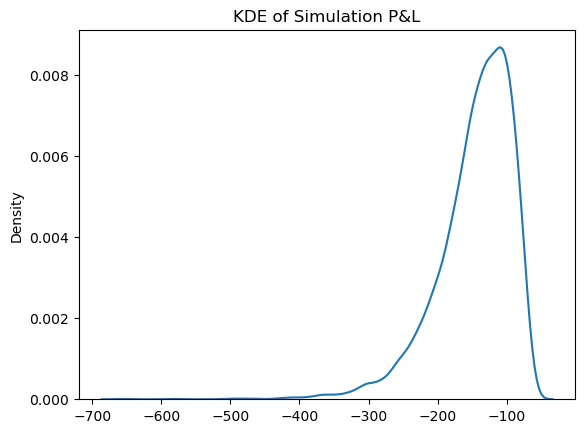

In [5]:

ax = sns.kdeplot(rewards_delta)
ax.set_title('KDE of Simulation P&L')
plt.show()

In [13]:


# Run simulations
num_simulations = 1000
reward_array = np.zeros(num_simulations)
for i in tqdm(range(num_simulations)):
    episode_reward = 0
    state,info = env.reset()
    done = False
    while not done:
        action = [0]
        state, reward, done, _ ,info = env.step(action)
        episode_reward += reward
    reward_array[i] = episode_reward

reward_array.mean()

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)
100%|██████████| 1000/1000 [00:28<00:00, 35.46it/s]


0.22037816200464544

In [14]:
reward_array.max()

119.2023721236688

In [15]:
reward_array.std()


180.11512989766794

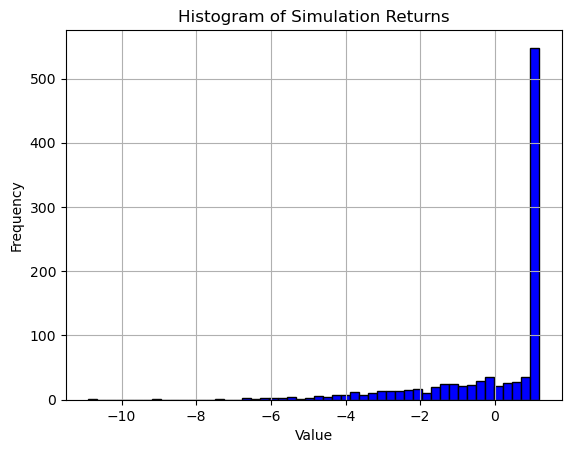

In [16]:
# Plotting the histogram
plt.hist(reward_array/L, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Simulation Returns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [17]:
# Initialize agent
agent = DeltaNeutralAgent()

proportion = np.zeros(1000)
for i in tqdm(range(1000)):
    state,info = env.reset()
    done = False
    count=0
    reward_history = np.zeros(env.num_steps)
    while not done:
        action = agent.act(state, info['delta'])
        state, reward, done, _ ,info = env.step(action)
        reward_history[count]=reward
        count+=1
    proportion[i] = reward_history[0]/reward_history.sum()
print(proportion.mean())





  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:33<00:00, 29.92it/s]

0.2689381355303167
